## Implmenting the Jaynes cumming model using density matrix 

* The goal of this notebook is to implement the **Jaynes-Cummings Hamiltonian** for the Transmon qubit and see the dynamics over time. For instance what happens if we have a single transmon qubit ($H_T = \omega_a \sigma^+ \sigma^-$) coupled to a single mode of a resonator ( $ H_R =  \omega_ca^+a $ ). 
* As we can see the the resonator hamiltonian and Transmon qubit hamiltonial looks same as simple harmonic oscillator. The coupling term between this two is given as $ H_{int} = g(a^+\sigma^- + a \sigma^+) $ .


So out Hamiltonian will look like: 

###     $ H = H_T + H_R + H_{int} = \omega_a \sigma^+ \sigma^- + \omega_ca^+a + g(a^+\sigma^- + a \sigma^+) $

The initial state of the qubit will look like as five levels of the resonator with the ground state occupied (means no photon in the system) and transmon in the exited state. We will put this two together as a tensor product between them to get the state that we can operate on with the hamiltonian H. 


           



### importing the libraries requaired

In [11]:

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

### implenenting the parameters

In [12]:
wc = 1.0  * 2 * np.pi  # resonator frequency
wa = 1.0  * 2 * np.pi  # transmon frequency
g  = 0.05 * 2 * np.pi  # coupling strength 
T = 1                 # Time range
Nt = 100               # number of steps
hbar = 1.0 / (2.0 *np.pi)  # $h\bar$ value 

### defining some functions 

In [13]:
def a(n):
    '''
        returns the annihilation operator for maximum n photons
    '''
    a = np.zeros((n+1,n+1))
    b = np.arange(1,n+1)
    np.fill_diagonal(a[:,1:],np.sqrt(b))
    return a

def adagger(n):
    '''
        returns the creation operator for maximum n photons
    '''
    return a(n).conj().T

def computeDensityMatrix(H, initialState, T, Nt):
    '''
        Take the Hamiltonian H and the intial state (density matrix) of the system and the time over which we want the dynamics.
        Returns final state density matrix and the time range 
    '''
    # getting eigunstates and eigunvalues for the Hamiltonian
    energies, states = np.linalg.eig(H)
    states_inverse = np.linalg.inv(states)
    num_states = H.shape[0]
    
    # defining the time range 
    timeRange = np.arange(0, T, T/Nt)
    
    # defining the time evolution part in the base of the eigunstates
    wjk = ((np.kron(energies, np.ones(num_states))
            - np.kron(np.ones(num_states), energies))/hbar).reshape(num_states, num_states)
    #print(wjk)
    Omega = np.exp(-1j * wjk[np.newaxis, :] * timeRange[:, np.newaxis, np.newaxis])
    #print(Omega.shape)
    
    # creating the intial density matrix by doing the tensor product of the intial state
    initial_rho = np.kron(initialState.transpose(), initialState)
    #print(initial_rho.shape)
    
    # transforming the intial density matrix to the density matrix with eigunstates basis
    rhoprime0 = np.matmul(np.matmul(states_inverse, initial_rho), states)
    
    # evolution of the density matrix in eigunstate basis 
    rhoprime_woNoise = Omega * rhoprime0
    
    # transforming it back to the intial base states 
    rho_woNoise = np.matmul(np.matmul(states, rhoprime_woNoise), states_inverse)
    
    return timeRange, rho_woNoise 

def partialTrace(rho, Na, Nb):
    Nt = rho.shape[0]
    rho_tensor = rho.reshape(Nt, Na, Nb, Na, Nb)
    rho_a = np.trace(rho_tensor, axis1=2, axis2=4)
    rho_b = np.trace(rho_tensor, axis1=1, axis2=3)
    return rho_a, rho_b

### implementing the operators and Hamiltonian 

In [14]:
sx = np.array([[0,1],[-1,0]])               # Pauli X operator
sy = np.array([[0,-1j],[1j,0]])             # pauli Y operator
sz = np.array([[1,0],[0,-1]])               # pauli z operator

# tensor product means Kronecker product, check np.kron(a,b)

A = np.kron(a(4),np.eye(2))            # for cavity annhilation operator (5,5) in tensor product with identity operator(2,2)
Adag = np.kron(adagger(4),np.eye(2))   # for cavity creation operator(5,5) in tensor product with identity operator (2,2)
sigplus = np.kron(np.eye(5),adagger(1))     # for transmon raising operator in tensor product with identity operator (5,5)
sigminus = np.kron(np.eye(5),a(1))          # for transmon lowering operator in tensor product with identity operator (5,5)
Sz = np.kron(np.eye(5),sz)                  # for transmon pauli z operator in tensor product with identity operator (5,5)


# Hamiltonian
H = wc * np.dot( Adag, A) + wa * np.dot(sigplus , sigminus) + g * (np.dot(Adag ,sigminus) + np.dot(A, sigplus))
#H = 0.5*wa*Sz + wc*np.dot(Adag,A)  + g*(np.dot(Adag,sigminus) + np.dot(A, sigplus)) 

In [15]:
def computeDensityMatrix(H, initialState, T, Nt):
    energies, states = np.linalg.eig(H)
    states_inverse = np.linalg.inv(states)
    num_states = H.shape[0]
    
    timeRange = np.arange(0, T, T/Nt)
    wjk = ((np.kron(energies, np.ones(num_states))
            - np.kron(np.ones(num_states), energies))/hbar).reshape(num_states, num_states)
    #print(wjk)
    Omega = np.exp(-1j * wjk[np.newaxis, :] * timeRange[:, np.newaxis, np.newaxis])
    #print(Omega.shape)
    initial_rho = np.kron(initialState.transpose(), initialState)
    #print(initial_rho.shape)
    rhoprime0 = np.matmul(np.matmul(states_inverse, initial_rho), states)
    rhoprime_woNoise = Omega * rhoprime0
    rho_woNoise = np.matmul(np.matmul(states, rhoprime_woNoise), states_inverse)
    return timeRange, rho_woNoise

def partialTrace(rho, Na, Nb):
    Nt = rho.shape[0]
    rho_tensor = rho.reshape(Nt, Na, Nb, Na, Nb)
    rho_a = np.trace(rho_tensor, axis1=2, axis2=4)
    rho_b = np.trace(rho_tensor, axis1=1, axis2=3)
    return rho_a, rho_b

### defining the initial state

In [19]:
T = 5
Nt = 100
initial_st = np.zeros((10,1))  # this is like a kron product between transmon state and resonator state
initial_st[1,:] = 1            # it says the transmon is in exited state and resonator is in ground state.
print(initial_st)



[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


### time evolution and ploting of transmon state probability over time

/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local

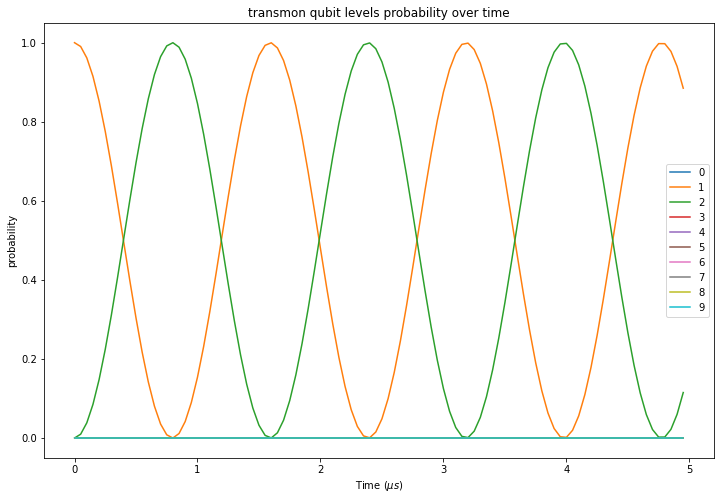

In [25]:
t, rho_zeroNoise =  computeDensityMatrix(H, initial_st, T, Nt)

fig, ax = plt.subplots(figsize=(12, 8))

def plotFlipFlopPopulation(t, rho_ff):
    for state in np.arange(rho_ff.shape[1]):
            k = ax.plot(t, rho_ff[:, state, state], label= state)
    return k

plotFlipFlopPopulation(t, rho_zeroNoise)
ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('probability')
ax.set_title('transmon qubit levels probability over time')
plt.legend()

In the top figure we can see how the probability revolves between $|1>$ and $ |2> $ states. intiaaly transmon was in the exited state and after some time it goes into ground states. and it comes back to exited state after some time again. This is known as **Vaccum Rabi oscillation**. This happens when the resonator and transmon qubit frequencies are same. What happens if they are not same. let's try that... 

/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pi/.local

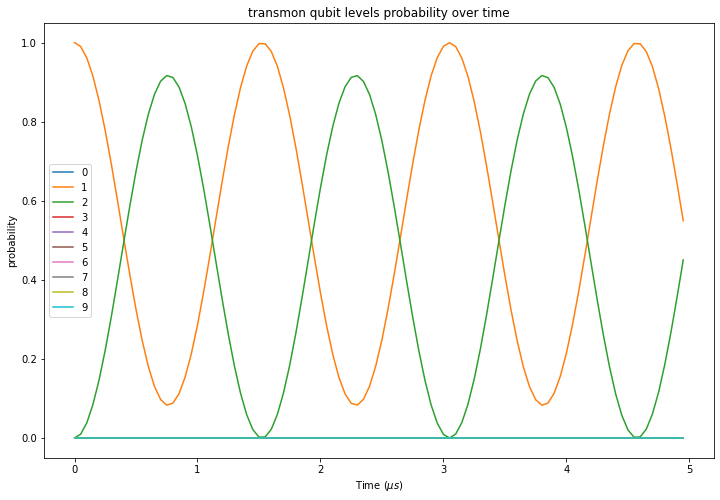

In [27]:
wc = 0.97  * 2 * np.pi  # resonator frequency
wa = 1.0  * 2 * np.pi  # transmon frequency
g  = 0.05 * 2 * np.pi  # coupling strength 

# Hamiltonian
H = wc * np.dot( Adag, A) + wa * np.dot(sigplus , sigminus) + g * (np.dot(Adag ,sigminus) + np.dot(A, sigplus))

# time evolution and ploting of transmon state probability over time
t, rho_zeroNoise =  computeDensityMatrix(H, initial_st, T, Nt)

fig, ax = plt.subplots(figsize=(12, 8))

def plotFlipFlopPopulation(t, rho_ff):
    for state in np.arange(rho_ff.shape[1]):
            k = ax.plot(t, rho_ff[:, state, state], label= state)
    return k

plotFlipFlopPopulation(t, rho_zeroNoise)
ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('probability')
ax.set_title('transmon qubit levels probability over time')
plt.legend()

### some key points when frequiencies are not same.

* As we can see now the oscillaton are happening but the probability of being in exited can not be zero entirely. 
* frequancy of oscillation (Rabi frequency) has incresed on of resonance.
* This entirely matches with our theoretical prediction of the Model.
* If we use other modules like qutip or qiskit, they also predict the same answer.